# Univariate analyses

Perform some univariate analyses to establish estimates of "ground truth" feature importance, after controlling for site effects.

In [1]:
import json
import pickle    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
    
from armed.models.lme import MixedLogisticGLM
from scipy import stats

Load pre-defined k-folds.

In [2]:
with open('./10x10_kfolds_top20sites.pkl', 'rb') as f:
    kfolds = pickle.load(f)
    
dfData = kfolds.x
arrLabels = kfolds.y.squeeze()
dfSite = kfolds.z

For the categorical features, compute relative risk stratified by site. 

In [3]:
lsVars = ['ApoE4 - 1 allele',
         'ApoE4 - 2 alleles',
         'Gender - Female',
         'Ethnicity - Hispanic/Latino', 
         'Race - Am Indian/Alaskan',
         'Race - Asian',
         'Race - Black',
         'Race - Multiple',
         'Marital Status - Divorced',
         'Marital Status - Never', 
         'Marital Status - Widowed']

def contingency_table(data, labels, var):
    nExposedConverters = np.sum((data[var] == 1) & (labels == 1))
    nUnexposedConverters = np.sum((data[var] == 0) & (labels == 1))
    nExposedNonconverters = np.sum((data[var] == 1) & (labels == 0))
    nUnexposedNonconverters = np.sum((data[var] == 0) & (labels == 0))

    return np.array([[nExposedConverters, nExposedNonconverters],
                     [nUnexposedConverters, nUnexposedNonconverters]])

dfRR = pd.DataFrame(columns=['Site', 'Variable', 'Relative Risk'])
iRow = 0

# for strExposure, strUnexposed in lsComparisons:
for strVar in lsVars:

    lsSiteContingency = []
    for iSite in range(dfSite.shape[1]):
        dfDataSite = dfData.loc[dfSite.iloc[:, iSite] == 1]
        arrLabelsSite = arrLabels[dfSite.iloc[:, iSite] == 1]
        arrSiteContingency = contingency_table(dfDataSite, arrLabelsSite, strVar)
        # Omit sites with zero exposed, unexposed, or unexposed converters
        if (arrSiteContingency[0, :].sum() > 0) & (arrSiteContingency[1, :].sum() > 0) & (arrSiteContingency[1, 0] > 0):
            rr = (arrSiteContingency[0, 0] / arrSiteContingency[0, :].sum()) \
                / (arrSiteContingency[1, 0] / arrSiteContingency[1, :].sum())
                
            dfRR.loc[iRow] = [dfSite.columns[iSite], strVar, rr]
            iRow += 1
                    
dfRR

,Site,Variable,Relative Risk
0,2,ApoE4 - 1 allele,1.142857
1,21,ApoE4 - 1 allele,2.250000
2,23,ApoE4 - 1 allele,0.666667
3,27,ApoE4 - 1 allele,2.666667
4,31,ApoE4 - 1 allele,1.178571
...,...,...,...
104,127,Marital Status - Widowed,4.666667
105,128,Marital Status - Widowed,4.000000
106,130,Marital Status - Widowed,1.333333
107,137,Marital Status - Widowed,2.500000


Plot the inter-site variance of each feature's relative risk.

Text(0.5, 0, 'Relative Risk s.d.')

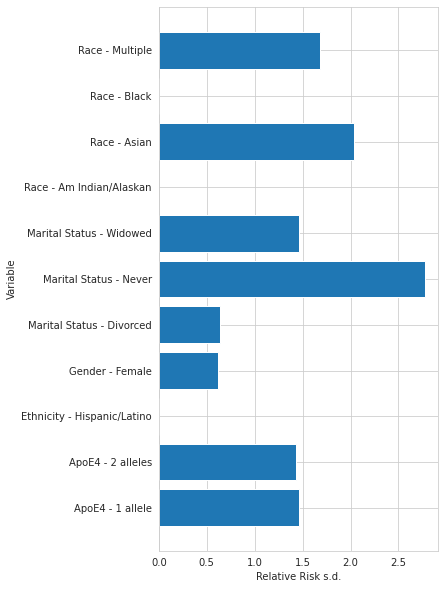

In [4]:
dfRRVar = dfRR.groupby('Variable').std()
fig, ax = plt.subplots(figsize=(5, 10))
ax.barh(y=dfRRVar.index, width=dfRRVar['Relative Risk'])
ax.set_ylabel('Variable')
ax.set_xlabel('Relative Risk s.d.')

In [5]:
dfRRVar.to_csv('./categorical_relativerisk_sd.csv')

For the continuous features, fit univariate logistic mixed effects models with site-specific random slopes and intercepts. 

In [6]:
lsVars = [
       'Years of education', 'Age', 'CDR-SB', 'ADAS11', 'ADAS13',
       'ADAS Word Recognition', 'MMSE', 'RAVLT immediate recall',
       'RAVLT learning score', 'RAVLT forgetting score', 'RAVLT % forgetting',
       'Trails B score', 'Functional Activities Questionnaire',
       'mPACC with Digit symbol substitution', 'mPACC with Trails B',
       'Ventricular volume', 'Hippocampal volume', 'Whole brain volume',
       'Entorhinal volume', 'Fusiform volume', 'Mid temporal volume',
       'Intracranial volume', 'PET FDG', 'CSF phosphorylated tau', 'CSF tau',
       'CSF beta-amyloid']

dfCoefs = pd.DataFrame(columns=['Coef', 'S.D.', 'Random slope S.D.'], index=lsVars)

for iRow, strVariable in enumerate(lsVars):

    strFormula = 'Conversion ~ Var'
    dfLogRegData = dfData[[strVariable]].copy()
    dfLogRegData.columns = ['Var']
    dfLogRegData['Conversion'] = arrLabels
    dfLogRegData['Site'] = dfSite.idxmax(axis=1)
    
    # Drop missing values
    dfLogRegData.dropna(inplace=True)
    # Drop sites with 100% or 0% conversion
    dfSiteConversionRate = dfLogRegData.groupby('Site')['Conversion'].mean()
    dfBadSites = dfSiteConversionRate.loc[(dfSiteConversionRate == 0) | (dfSiteConversionRate == 1)]
    dfLogRegData = dfLogRegData.loc[~dfLogRegData['Site'].isin(dfBadSites.index)]

    dfLogRegData['Var'] -= dfLogRegData['Var'].mean()
    dfLogRegData['Var'] /= dfLogRegData['Var'].std()

    # Logistic mixed effects model with site-specific random slope and intercept
    mixedeffects = MixedLogisticGLM('Conversion ~ Var', 
                                    {'Site_slope': '0 + C(Site):Var',
                                        'Site_intercept': 'C(Site)'},
                                    'Site')
                
    mixedeffects.fit(dfLogRegData)
    coef = mixedeffects.result.fe_mean[1]
    sd = mixedeffects.result.fe_sd[1]
        
    # Compute random slope s.d.
    dfRE = mixedeffects.result.random_effects()
    dfRESlopes = dfRE.loc[['Var' in x for x in dfRE.index]]
    re_sd = dfRESlopes['Mean'].std()

    dfCoefs.loc[strVariable] = [coef, sd, re_sd]
    
dfCoefs

,Coef,S.D.,Random slope S.D.
Years of education,-0.0526124,0.116909,0.071996
Age,0.304627,0.120916,0.114411
CDR-SB,1.08176,0.134881,0.229683
ADAS11,1.41601,0.153318,0.241421
ADAS13,1.59391,0.159107,0.279189
ADAS Word Recognition,1.30647,0.140108,0.270639
MMSE,-0.769754,0.122371,0.216995
RAVLT immediate recall,-1.55386,0.160542,0.0561487
RAVLT learning score,-0.813063,0.134996,0.170272
RAVLT forgetting score,0.270179,0.122214,0.119079


Plot the inter-site variance of each feature's random slopes.

Text(0.5, 0, 'Random slope s.d.')

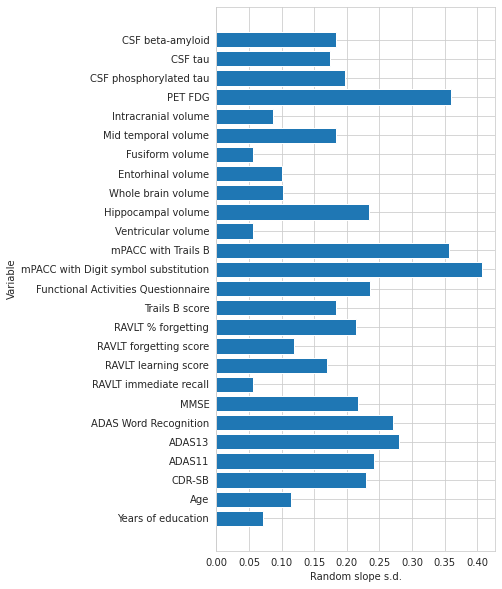

In [7]:
fig, ax = plt.subplots(figsize=(5, 10))
ax.barh(y=dfCoefs.index, width=dfCoefs['Random slope S.D.'])
ax.set_ylabel('Variable')
ax.set_xlabel('Random slope s.d.')

In [8]:
dfCoefs.to_csv('./continuous_univariate_lme.csv')